In [ ]:
# This notebook contains experiments that are meant to show a progression of ensembling methods
# in simple settings to progressively more complex settings.
# I only focus on problems with categorical targets, and compare how they perform to comprable continuous targets.

# Checklist for experiments:
# - [x] Try a 1-layer ensemble classification problem where the targets are generated by binning a continuous variable.
#       Compare the learning curve to that of simply doing regression with and without ensembling.
# - [ ] Repeat the same as above but use HL-Gauss to generate the targets and calculate losses.
# - [ ] If these work well, try them with the 2-layer GEOFF task using only feature search.
#       Generate results for base learning network size scaling, target input scaling, and level of stochasticity.

In [76]:
import time
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from phd.feature_search.core.models import LTU, MultipleLinear, ParallelLinear

%matplotlib inline

## 1-Layer continuous -> categorical classification experiment

In [ ]:
def run_1l_classification_experiment(
    n_train_samples: int,
    n_inputs: int,
    n_members: int,
    n_target_bins: int,
    step_size: float = 0.01,
    noise_std: float = 0.0,
    device: str = 'cpu',
    seed: Optional[int] = None,
):
    seed = int(time.time() * 1000) if seed is None else seed
    torch.manual_seed(seed)

    # Generate random weights for the input features
    target_model = nn.Linear(n_inputs, 1, device=device)
    
    # Generate random weights for the ensemble using ParallelLinear
    # Output should be categorical logits for each bin
    ensemble_model = ParallelLinear(
        in_features = n_inputs,
        out_features = n_target_bins,
        n_parallel = n_members,
        bias = True,
        generator = torch.Generator().manual_seed(seed + 1)
    ).to(device)
    
    # Create an RMSProp optimizer for the ensemble
    optimizer = optim.RMSprop(ensemble_model.parameters(), lr=step_size)
    
    # Generate a set of input samples
    inputs = torch.randn(n_train_samples, n_inputs, device=device)
    
    # Generate targets for each input sample with a pass through the target model using a normal distribution
    with torch.no_grad():
        continuous_targets = target_model(inputs).squeeze(-1)  # Shape: (n_train_samples,)
        # Add some noise to make it more realistic
        noise = torch.randn_like(continuous_targets) * noise_std
        continuous_targets = continuous_targets + noise
    
    # Create the bin boundaries as being uniform with the edges forming a 99% interval
    # for values sampled from a normal distribution
    target_mean = 0.0
    target_std = 1.0
    # Use 99% confidence interval
    lower_bound = target_mean - 2.576 * target_std
    upper_bound = target_mean + 2.576 * target_std
    bin_edges = torch.linspace(lower_bound, upper_bound, n_target_bins + 1, device=device)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Count targets that fall outside the bin edges (outliers)
    n_outliers = ((continuous_targets < bin_edges[0]) | 
                  (continuous_targets > bin_edges[-1])).sum().item()
    pct_outliers = 100 * n_outliers / n_train_samples
    print(f"Percentage of outlier targets: {pct_outliers:.2f}%")
    
    # Generate categorical targets by binning the continuous targets
    categorical_targets = torch.bucketize(continuous_targets, bin_edges, right=False) - 1
    # Ensure targets are within valid range [0, n_target_bins-1]
    categorical_targets = torch.clamp(categorical_targets, 0, n_target_bins - 1)
    
    # Create a dict of lists to store metrics
    metrics = {
        'mean_ensemble_loss': [],
        'continuous_loss': [],
        'categorical_accuracy': [],
        'prediction_entropy': [], # Added entropy metric
    }
    
    # For each sample:
    for i in range(n_train_samples):
        # Get the step's input and output
        input_sample = inputs[i:i+1]  # Shape: (1, n_inputs)
        cat_target = categorical_targets[i:i+1]  # Shape: (1,)
        cont_target = continuous_targets[i:i+1]  # Shape: (1,)
        
        # Forward pass through ensemble
        ensemble_outputs = ensemble_model(input_sample)  # Shape: (1, n_members, n_target_bins)
        
        # Each ensemble member should be trained independently on the categorical target
        # Calculate cross-entropy loss for each member
        # Shape: (1, n_members, n_target_bins) -> (n_members, n_target_bins)
        member_logits = ensemble_outputs.squeeze(0)
        # Expand targets to match each member
        expanded_targets = cat_target.expand(n_members)
        # Calculate loss for all members at once
        cat_loss = F.cross_entropy(member_logits, expanded_targets, reduction='sum')
        
        # Calculate ensemble predictions for majority voting
        # Get predictions from each member and collate with majority vote
        member_predictions = torch.argmax(ensemble_outputs, dim=2)  # Shape: (1, n_members)
        ensemble_cat_pred = torch.mode(member_predictions.squeeze(0)).values  # Shape: (,)
        
        # Train on the one step with RMSProp
        optimizer.zero_grad()
        cat_loss.backward()
        optimizer.step()
        
        # Log the loss and the loss when converting the prediction back to a continuous variable
        with torch.no_grad():
            # Calculate accuracy for categorical prediction using majority vote
            cat_accuracy = (ensemble_cat_pred == cat_target.squeeze()).float().mean().item()
            
            # Calculate MSE for continuous prediction
            ensemble_cont_pred = bin_centers[ensemble_cat_pred]  # Shape: (,)
            cont_loss = F.mse_loss(ensemble_cont_pred, cont_target.squeeze()).item()
            
            # Calculate entropy of member predictions
            pred_counts = torch.bincount(member_predictions.squeeze(), minlength=n_target_bins)
            pred_probs = pred_counts.float() / n_members
            entropy = -torch.sum(pred_probs * torch.log(pred_probs + 1e-10)).item()
            
            metrics['mean_ensemble_loss'].append(cat_loss.item() / n_members)
            metrics['continuous_loss'].append(cont_loss)
            metrics['categorical_accuracy'].append(cat_accuracy)
            metrics['prediction_entropy'].append(entropy)
    
    # Return a tuple that contains the ensemble model, target model, loss, and dict of metrics
    return ensemble_model, target_model, metrics

In [73]:
learning_model, target_model, metrics = run_1l_classification_experiment(
    n_train_samples = 2000,
    n_inputs = 10,
    n_members = 20,
    n_target_bins = 20,
    step_size = 0.01,
    noise_std = 0.0,
    device = 'cpu',
    seed = 542,
)

Percentage of outlier targets: 0.05%


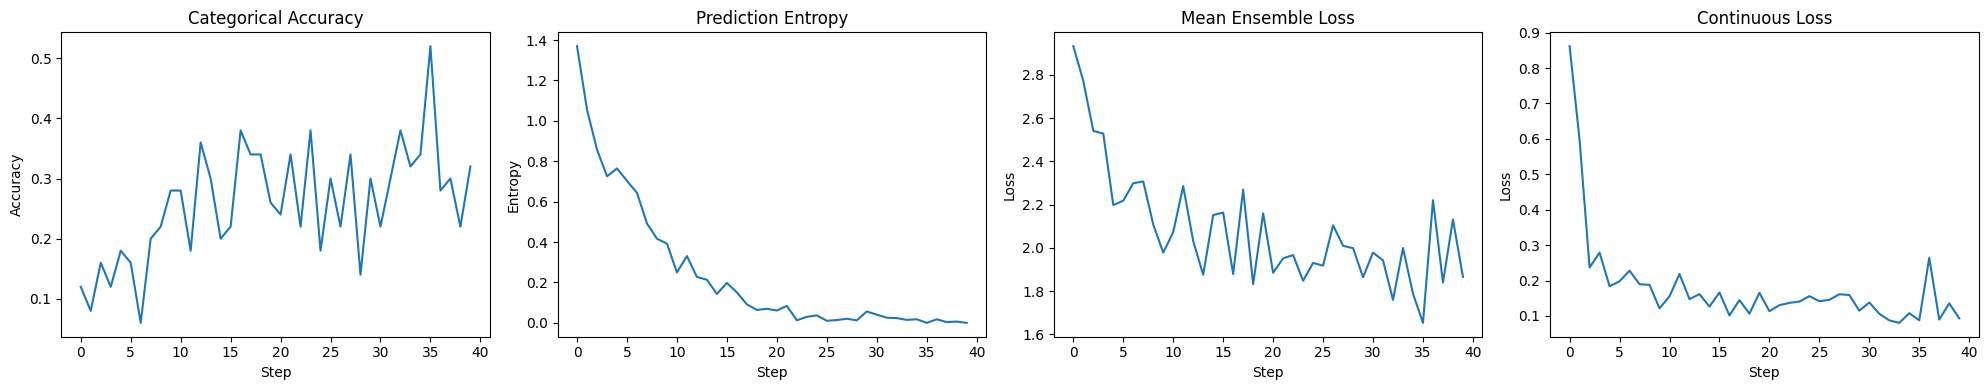

In [74]:
bin_size = 50

# Convert to numpy array and reshape into groups of bin_size
acc_array = np.array(metrics['categorical_accuracy'])
n_bins = len(acc_array) // bin_size
acc_binned = acc_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

ent_array = np.array(metrics['prediction_entropy'])
ent_binned = ent_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

loss_array = np.array(metrics['mean_ensemble_loss'])
loss_binned = loss_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

cont_array = np.array(metrics['continuous_loss'])
cont_binned = cont_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

# Plot the smoothed metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

sns.lineplot(data=acc_binned, ax=ax1)
ax1.set_title('Categorical Accuracy')
ax1.set_xlabel('Step')
ax1.set_ylabel('Accuracy')

sns.lineplot(data=ent_binned, ax=ax2)
ax2.set_title('Prediction Entropy') 
ax2.set_xlabel('Step')
ax2.set_ylabel('Entropy')

sns.lineplot(data=loss_binned, ax=ax3)
ax3.set_title('Mean Ensemble Loss')
ax3.set_xlabel('Step')
ax3.set_ylabel('Loss')

sns.lineplot(data=cont_binned, ax=ax4)
ax4.set_title('Continuous Loss')
ax4.set_xlabel('Step')
ax4.set_ylabel('Loss')

plt.tight_layout()

## 2-Layer continuous -> categorical classification experiment

In [ ]:
# Ensembling did not help in the previous line of experiments because the members were not diverse.
# This is inevitable when working with linear learning models.
# Next I will move on to something more similar to the 2-layer GEOFF problems I've been working with,
# but I will force the features generated to be different by manually setting the weights for the first layer.

In [140]:
def run_2l_classification_experiment(
    n_train_samples: int,
    n_inputs: int,
    n_hidden_units: int,
    n_members: int,
    n_target_bins: int,
    input_weight_correct_fraction: float = 0.5,
    step_size: float = 0.01,
    noise_std: float = 0.0,
    device: str = 'cpu',
    seed: Optional[int] = None,
):
    seed = int(time.time() * 1000) if seed is None else seed
    torch.manual_seed(seed)
    
    ### Generate inputs ###
    
    inputs = torch.randn(n_train_samples, n_inputs, device=device)

    ### Init target model ###

    target_model = nn.Sequential(
        nn.Linear(n_inputs, n_hidden_units, device=device, bias=False),
        LTU(),
        nn.Linear(n_hidden_units, 1, device=device)
    )
    
    target_input_layer = target_model[0]
    target_input_layer.weight.data = torch.randint(
        0, 2, target_input_layer.weight.shape, device=target_input_layer.weight.device,
        generator=torch.Generator(device=device).manual_seed(seed + 1),
    ).float() * 2 - 1
    
    ### Compute target values ###
    
    with torch.no_grad():
        continuous_targets = target_model(inputs).squeeze(-1)  # Shape: (n_train_samples,)
        noise = torch.randn_like(continuous_targets) * noise_std
        continuous_targets = continuous_targets + noise
        
    target_mean = 0.0
    target_std = 1.0
    lower_bound = target_mean - 2.576 * target_std # Use 99% confidence interval
    upper_bound = target_mean + 2.576 * target_std
    bin_edges = torch.linspace(lower_bound, upper_bound, n_target_bins + 1, device=device)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    categorical_targets = torch.bucketize(continuous_targets, bin_edges, right=False) - 1
    categorical_targets = torch.clamp(categorical_targets, 0, n_target_bins - 1)
    
    n_outliers = ((continuous_targets < bin_edges[0]) | 
                  (continuous_targets > bin_edges[-1])).sum().item()
    pct_outliers = 100 * n_outliers / n_train_samples
    print(f"Percentage of outlier targets: {pct_outliers:.2f}%")
    
    ### Init learning model ###
    
    ensemble_model = nn.Sequential(
        ParallelLinear(
            in_features = n_inputs,
            out_features = n_hidden_units,
            n_parallel = n_members,
            bias = False,
        ),
        LTU(),
        MultipleLinear(
            in_features = n_hidden_units,
            out_features = n_target_bins,
            n_parallel = n_members,
            bias = True,
            generator = torch.Generator().manual_seed(seed + 2)
        ).to(device)
    )
    
    ### Set the first layer to partially correct values, then freeze it ###

    n_incorrect = int(n_inputs * n_hidden_units * (1 - input_weight_correct_fraction))
    ideal_weights = target_input_layer.weight.data.clone()
    new_input_weights = ideal_weights.repeat(n_members, 1, 1) # Size: (n_members, n_hidden_units, n_inputs)
    for i in range(n_members):
        incorrect_idxs = np.random.choice(n_inputs * n_hidden_units, size=n_incorrect, replace=False)
        incorrect_idxs = np.unravel_index(incorrect_idxs, (n_hidden_units, n_inputs))
        new_input_weights[i, incorrect_idxs[0], incorrect_idxs[1]] = -new_input_weights[i, incorrect_idxs[0], incorrect_idxs[1]]
    
    ensemble_model[0].weight.data = new_input_weights.reshape(*ensemble_model[0].weight.shape)
    ensemble_model[0].weight.requires_grad = False
    
    # Create an RMSProp optimizer for the ensemble
    optimizer = optim.RMSprop(ensemble_model.parameters(), lr=step_size)
    
    # Create a dict of lists to store metrics
    metrics = {
        'mean_ensemble_loss': [],
        'continuous_loss': [],
        'categorical_accuracy': [],
        'prediction_entropy': [], # Added entropy metric
    }
    
    # For each sample:
    for i in range(n_train_samples):
        # Get the step's input and output
        input_sample = inputs[i:i+1]  # Shape: (1, n_inputs)
        cat_target = categorical_targets[i:i+1]  # Shape: (1,)
        cont_target = continuous_targets[i:i+1]  # Shape: (1,)
        
        # Forward pass through ensemble
        ensemble_outputs = ensemble_model(input_sample)  # Shape: (1, n_members, n_target_bins)
        
        # Each ensemble member should be trained independently on the categorical target
        # Calculate cross-entropy loss for each member
        # Shape: (1, n_members, n_target_bins) -> (n_members, n_target_bins)
        member_logits = ensemble_outputs.squeeze(0)
        # Expand targets to match each member
        expanded_targets = cat_target.expand(n_members)
        # Calculate loss for all members at once
        cat_loss = F.cross_entropy(member_logits, expanded_targets, reduction='sum')
        
        # Calculate ensemble predictions for majority voting
        # Get predictions from each member and collate with majority vote
        member_predictions = torch.argmax(ensemble_outputs, dim=2)  # Shape: (1, n_members)
        ensemble_cat_pred = torch.mode(member_predictions.squeeze(0)).values  # Shape: (,)
        
        # Train on the one step with RMSProp
        optimizer.zero_grad()
        cat_loss.backward()
        optimizer.step()
        
        # Log the loss and the loss when converting the prediction back to a continuous variable
        with torch.no_grad():
            # Calculate accuracy for categorical prediction using majority vote
            cat_accuracy = (ensemble_cat_pred == cat_target.squeeze()).float().mean().item()
            
            # Calculate MSE for continuous prediction
            ensemble_cont_pred = bin_centers[ensemble_cat_pred]  # Shape: (,)
            cont_loss = F.mse_loss(ensemble_cont_pred, cont_target.squeeze()).item()
            
            # Calculate entropy of member predictions
            pred_counts = torch.bincount(member_predictions.squeeze(), minlength=n_target_bins)
            pred_probs = pred_counts.float() / n_members
            entropy = -torch.sum(pred_probs * torch.log(pred_probs + 1e-10)).item()
            
            metrics['mean_ensemble_loss'].append(cat_loss.item() / n_members)
            metrics['continuous_loss'].append(cont_loss)
            metrics['categorical_accuracy'].append(cat_accuracy)
            metrics['prediction_entropy'].append(entropy)
    
    # Return a tuple that contains the ensemble model, target model, loss, and dict of metrics
    return ensemble_model, target_model, metrics

In [ ]:
learning_model, target_model, metrics = run_2l_classification_experiment(
    n_train_samples = 5000,
    n_inputs = 80,
    n_hidden_units = 20,
    n_members = 2,
    n_target_bins = 20,
    input_weight_correct_fraction = 0.6,
    step_size = 0.0003,
    noise_std = 0.0,
    device = 'cpu',
    seed = 1,
)

Percentage of outlier targets: 0.00%


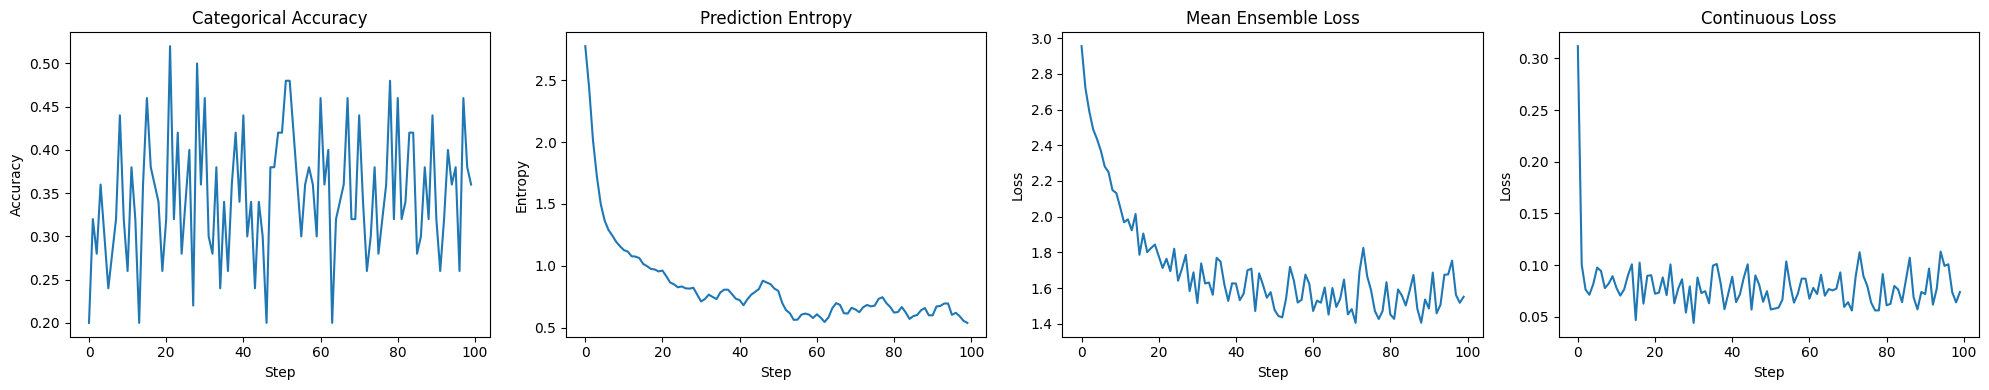

In [191]:
bin_size = 50

# Convert to numpy array and reshape into groups of bin_size
acc_array = np.array(metrics['categorical_accuracy'])
n_bins = len(acc_array) // bin_size
acc_binned = acc_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

ent_array = np.array(metrics['prediction_entropy'])
ent_binned = ent_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

loss_array = np.array(metrics['mean_ensemble_loss'])
loss_binned = loss_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

cont_array = np.array(metrics['continuous_loss'])
cont_binned = cont_array[:n_bins*bin_size].reshape(-1, bin_size).mean(axis=1)

# Plot the smoothed metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

sns.lineplot(data=acc_binned, ax=ax1)
ax1.set_title('Categorical Accuracy')
ax1.set_xlabel('Step')
ax1.set_ylabel('Accuracy')

sns.lineplot(data=ent_binned, ax=ax2)
ax2.set_title('Prediction Entropy') 
ax2.set_xlabel('Step')
ax2.set_ylabel('Entropy')

sns.lineplot(data=loss_binned, ax=ax3)
ax3.set_title('Mean Ensemble Loss')
ax3.set_xlabel('Step')
ax3.set_ylabel('Loss')

sns.lineplot(data=cont_binned, ax=ax4)
ax4.set_title('Continuous Loss')
ax4.set_xlabel('Step')
ax4.set_ylabel('Loss')

plt.tight_layout()

In [112]:
target_model[0].weight

Parameter containing:
tensor([[ 1.,  1.,  1.],
        [ 1., -1.,  1.],
        [ 1., -1., -1.],
        [ 1., -1.,  1.],
        [ 1., -1., -1.]], requires_grad=True)

In [113]:
learning_model[0].weight

Parameter containing:
tensor([[[-1.,  1., -1.],
         [ 1., -1., -1.],
         [ 1.,  1., -1.],
         [-1.,  1.,  1.],
         [-1., -1., -1.]],

        [[-1.,  1.,  1.],
         [-1.,  1., -1.],
         [-1., -1., -1.],
         [ 1., -1.,  1.],
         [-1.,  1., -1.]],

        [[ 1., -1., -1.],
         [ 1., -1., -1.],
         [ 1., -1., -1.],
         [ 1.,  1., -1.],
         [ 1.,  1.,  1.]],

        [[-1., -1.,  1.],
         [ 1., -1.,  1.],
         [ 1., -1., -1.],
         [ 1.,  1., -1.],
         [-1.,  1.,  1.]],

        [[ 1., -1., -1.],
         [ 1., -1., -1.],
         [-1.,  1., -1.],
         [ 1., -1.,  1.],
         [-1.,  1., -1.]]])